# sbert

In [11]:
!pip install spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl
!pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.8.0/fr_core_news_sm-3.8.0-py3-none-any.whl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.0 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 51.9 MB/s eta 0:00:00a 0:00:01


In [12]:
import importlib
import data_preprocessing  # Make sure it's already imported
importlib.reload(data_preprocessing)  # Force reload

<module 'data_preprocessing' from '/home/onyxia/work/data_preprocessing.py'>

In [13]:
import pandas as pd
import numpy as np
import data_preprocessing
from data_preprocessing import clean_text, correct_spelling, replace_emoji

In [14]:
df = pd.read_parquet("dataset.parquet")
label_df = df[df['label'] == True]

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_train_label, df_test_label = train_test_split(label_df, test_size=0.2,random_state=42)

In [16]:
# data preprocessing, skip lemmanization for bert and sbert
def process_text_pipeline(text, country):
    text = clean_text(text)
    text = correct_spelling(text, country)
    text = replace_emoji(text, country)
    return text

# process for df_train
processed_texts = []
# Iterate through the DataFrame rows
for index, row in df_train_label.iterrows():
    processed_text = process_text_pipeline(row['quote_text'], row['country_name'])
    processed_texts.append(processed_text)

# Assign lists back to the DataFrame
df_train_label['processed_text_nsc'] = processed_texts

# Repeat for df_test
processed_texts = []

for index, row in df_test_label.iterrows():
    processed_text = process_text_pipeline(row['quote_text'], row['country_name'])
    processed_texts.append(processed_text)

df_test_label['processed_text_nsc'] = processed_texts


In [ ]:
!pip install sentence_transformers

In [19]:
# Sentence-BERT (SBERT)
from sentence_transformers import SentenceTransformer
# Load pre-trained SBERT model
sbert_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

def get_sbert_embedding(text):
    """Generates sentence embedding using SBERT."""
    return sbert_model.encode(text)

# get embedding for training set
embedded_texts = []

# Iterate through the DataFrame rows
for index, row in df_train_label.iterrows():
    embedded_text = get_sbert_embedding(row['processed_text_nsc'])
    embedded_texts.append(embedded_text)

# Assign lists back to the DataFrame
df_train_label['sbert_embedding'] = embedded_texts

# for test set
embedded_texts = []

# Iterate through the DataFrame rows
for index, row in df_test_label.iterrows():
    embedded_text = get_sbert_embedding(row['processed_text_nsc'])
    embedded_texts.append(embedded_text)

# Assign lists back to the DataFrame
df_test_label['sbert_embedding'] = embedded_texts


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
# Assign lists back to the DataFrame
df_train_label['sbert_embedding'] = embedded_texts

# for test set
embedded_texts = []

# Iterate through the DataFrame rows
for index, row in df_test_label.iterrows():
    embedded_text = get_sbert_embedding(row['processed_text_nsc'])
    embedded_texts.append(embedded_text)

# Assign lists back to the DataFrame
df_test_label['sbert_embedding'] = embedded_texts

In [67]:
len(embedded_text)

384

**kmeans**

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Prepare SBERT embeddings
# Convert embeddings from lists to NumPy arrays
df_train_label['sbert_embedding'] = df_train_label['sbert_embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=" ") if isinstance(x, str) else np.array(x))
# Stack embeddings properly
X = np.vstack(df_train_label['sbert_embedding'].values)

# Apply K-Means clustering
k = 11  # Number of clusters, 10 topics add out of topic
kmeans = KMeans(n_clusters=k, random_state=42)
df_train_label['cluster'] = kmeans.fit_predict(X)

In [ ]:
# Group by cluster and topic_id to see distribution
cluster_topic_distribution = df_train_label.groupby(['cluster', 'topic_id']).size().reset_index(name='count')

# Find the most common topic_id in each cluster
cluster_to_topic = cluster_topic_distribution.sort_values('count', ascending=False).drop_duplicates('cluster')

# Create a mapping from cluster to topic_id
cluster_topic_mapping = dict(zip(cluster_to_topic['cluster'], cluster_to_topic['topic_id']))

# Assign the matched topic_id back to the DataFrame
df_train_label['matched_topic_id'] = df_train_label['cluster'].map(cluster_topic_mapping)

# Check the mapping
print(df_train_label[['quote_text', 'cluster', 'topic_id', 'matched_topic_id']].head())

In [74]:
# predict for df_test
df_test_label['sbert_embedding'] = df_test_label['sbert_embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=" ") if isinstance(x, str) else np.array(x))
X = np.vstack(df_test_label['sbert_embedding'].values)#.astype(np.float64)
df_test_label['cluster'] = kmeans.predict(X)
# map to the topic id
df_test_label['matched_topic_id'] = df_test_label['cluster'].map(cluster_topic_mapping)

In [75]:
train_accuracy = np.sum(df_train_label['matched_topic_id'] == df_train_label['topic_id'])/len(df_train_label)
test_accuracy = np.sum(df_test_label['matched_topic_id'] == df_test_label['topic_id'])/len(df_test_label)
print('train accuracy:', train_accuracy)
print('test accuracy:', test_accuracy)

train accuracy: 0.4351297405189621
test accuracy: 0.4421838784445017


**GMM**

In [48]:
X_train_sbert = np.vstack(df_train_label["sbert_embedding"].values)  # Shape: (num_samples, 384)
X_test_sbert = np.vstack(df_test_label["sbert_embedding"].values)

In [45]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=11, random_state=42)
df_train_label["sbert_cluster"] = gmm.fit_predict(X_train_sbert)

# Check cluster distribution
print(df_train_label["sbert_cluster"].value_counts())


sbert_cluster
5     2002
9     1866
0     1849
4     1686
2     1620
7     1615
1     1370
8     1139
10     953
6      945
3      486
Name: count, dtype: int64


In [72]:
# Group by cluster and topic_id to see distribution
cluster_topic_distribution = df_train_label.groupby(['sbert_cluster', 'topic_id']).size().reset_index(name='count')

# Find the most common topic_id in each cluster
cluster_to_topic = cluster_topic_distribution.sort_values('count', ascending=False).drop_duplicates('sbert_cluster')

# Create a mapping from cluster to topic_id
cluster_topic_mapping = dict(zip(cluster_to_topic['sbert_cluster'], cluster_to_topic['topic_id']))

# Assign the matched topic_id back to the DataFrame
df_train_label['matched_topic_id'] = df_train_label['sbert_cluster'].map(cluster_topic_mapping)

# Check the mapping
print(df_train_label[['quote_text', 'sbert_cluster', 'topic_id', 'matched_topic_id']].head())

                                              quote_text  sbert_cluster  \
38030  The face cream was easy to pump out and I didn...              7   
50679  Très bonne idée la recharge, pour partir en vo...              0   
35584  J’utilise ce produit depuis 2 mois maintenant ...              7   
44679  This set of 3 masks comes in a fully recycled ...              6   
33645  Points forts    Format automatique pratique, s...              1   

       topic_id  matched_topic_id  
38030     550.0             550.0  
50679     556.0             546.0  
35584     546.0             550.0  
44679     602.0             602.0  
33645     546.0             602.0  


In [50]:
# predict for df_test
df_test_label['sbert_cluster'] = gmm.predict(X_test_sbert)
# map to the topic id
df_test_label['matched_topic_id'] = df_test_label['sbert_cluster'].map(cluster_topic_mapping)

In [51]:
train_accuracy = np.sum(df_train_label['matched_topic_id'] == df_train_label['topic_id'])/len(df_train_label)
test_accuracy = np.sum(df_test_label['matched_topic_id'] == df_test_label['topic_id'])/len(df_test_label)
print('train accuracy:', train_accuracy)
print('test accuracy:', test_accuracy)

train accuracy: 0.4374476852746121
test accuracy: 0.3940252382178728


**Agglomerative**

In [52]:
from sklearn.cluster import AgglomerativeClustering


# Run Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=11)
df_train_label["sbert_cluster"] = agglo.fit_predict(X_train_sbert)

print(df_train_label["sbert_cluster"].value_counts())  # Check cluster distribution


sbert_cluster
0     2942
1     2743
3     1760
7     1630
2     1525
4     1301
5     1267
6      807
10     643
9      470
8      443
Name: count, dtype: int64


In [58]:
from scipy.spatial.distance import cdist

# Find cluster centroids based on training data
cluster_centroids = np.array([X_train_sbert[df_train_label["sbert_cluster"] == i].mean(axis=0) for i in range(num_clusters)])

# Assign test data to nearest cluster centroid
test_cluster_assignments = np.argmin(cdist(X_test_sbert, cluster_centroids), axis=1)

# Save test cluster labels
df_test_label["sbert_cluster"] = test_cluster_assignments
# map to the topic id
df_test_label['matched_topic_id'] = df_test_label['sbert_cluster'].map(cluster_topic_mapping)

In [59]:
train_accuracy = np.sum(df_train_label['matched_topic_id'] == df_train_label['topic_id'])/len(df_train_label)
test_accuracy = np.sum(df_test_label['matched_topic_id'] == df_test_label['topic_id'])/len(df_test_label)
print('train accuracy:', train_accuracy)
print('test accuracy:', test_accuracy)

train accuracy: 0.3699697379434679
test accuracy: 0.255472572753026


**t-sne combined with kmeans**

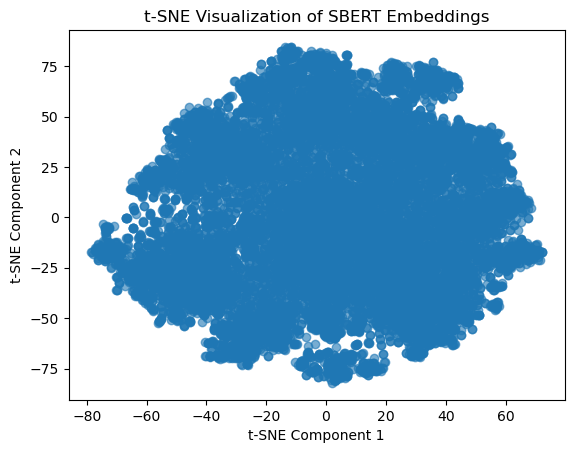

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce SBERT embeddings to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_sbert_tsne = tsne.fit_transform(X_train_sbert)

# Scatter plot of t-SNE reduced embeddings
plt.scatter(X_sbert_tsne[:, 0], X_sbert_tsne[:, 1], alpha=0.6)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of SBERT Embeddings")
plt.show()


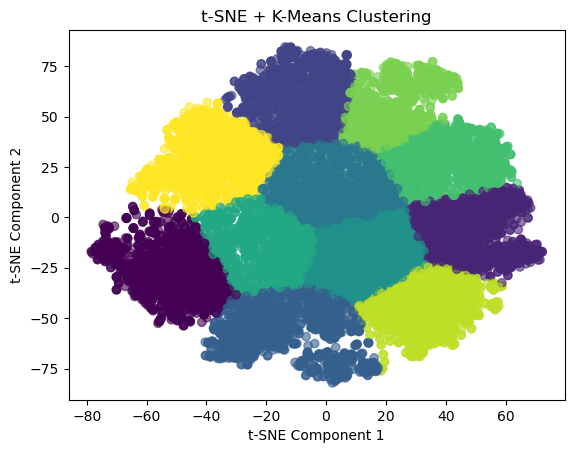

In [61]:
from sklearn.cluster import KMeans

num_clusters = 11
kmeans_tsne = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

df_train_label["cluster"] = kmeans_tsne.fit_predict(X_sbert_tsne)

# Scatter plot with clusters
plt.scatter(X_sbert_tsne[:, 0], X_sbert_tsne[:, 1], c=df_train_label["cluster"], cmap="viridis", alpha=0.6)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE + K-Means Clustering")
plt.show()


In [64]:
X_sbert_tsne_test = tsne.fit_transform(X_test_sbert)
df_test_label['cluster'] = kmeans_tsne.predict(X_sbert_tsne_test)
# map to the topic id
df_test_label['matched_topic_id'] = df_test_label['cluster'].map(cluster_topic_mapping)

In [65]:
train_accuracy = np.sum(df_train_label['matched_topic_id'] == df_train_label['topic_id'])/len(df_train_label)
test_accuracy = np.sum(df_test_label['matched_topic_id'] == df_test_label['topic_id'])/len(df_test_label)
print('train accuracy:', train_accuracy)
print('test accuracy:', test_accuracy)

train accuracy: 0.3699697379434679
test accuracy: 0.1035281998454803


**PCA with kmean**

In [76]:
from sklearn.decomposition import PCA

# Reduce SBERT embeddings from 384D to 50D using PCA
pca = PCA(n_components=100, random_state=42)
X_sbert_pca = pca.fit_transform(X_train_sbert)

print(f"Explained variance after PCA: {sum(pca.explained_variance_ratio_):.4f}")  # Should be close to 1.0

Explained variance after PCA: 0.9188


In [81]:
from sklearn.cluster import KMeans

num_clusters = 11
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

df_train_label["cluster"] = kmeans_pca.fit_predict(X_sbert_pca)

In [82]:
X_sbert_pca_test = pca.transform(X_test_sbert)
df_test_label['cluster'] = kmeans_pca.predict(X_sbert_pca_test)
# map to the topic id
df_test_label['matched_topic_id'] = df_test_label['cluster'].map(cluster_topic_mapping)

In [83]:
train_accuracy = np.sum(df_train_label['matched_topic_id'] == df_train_label['topic_id'])/len(df_train_label)
test_accuracy = np.sum(df_test_label['matched_topic_id'] == df_test_label['topic_id'])/len(df_test_label)
print('train accuracy:', train_accuracy)
print('test accuracy:', test_accuracy)

train accuracy: 0.3699697379434679
test accuracy: 0.0836981715168684


# bert

In [ ]:
!pip install transformers torch

In [41]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT base model and tokenizer
# for now try the most basic pretrained
bert_model_name = "bert-base-uncased"  
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name)


In [43]:
def get_bert_word_embeddings(text, model, tokenizer):
    """
    Extracts word embeddings from BERT for a given text.

    Parameters:
    - text (str): Input text
    - model (transformers.BertModel): Pretrained BERT model
    - tokenizer (transformers.BertTokenizer): BERT tokenizer

    Returns:
    - word_embeddings (numpy array): Word-level embeddings
    """
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**tokens)

    # Get last hidden states (shape: [batch_size, num_tokens, embedding_size])
    last_hidden_state = outputs.last_hidden_state
    return last_hidden_state.squeeze(0).numpy()  # Convert tensor to numpy



In [ ]:
embedded_texts = []

# Iterate through the DataFrame rows
for index, row in df_train_label.iterrows():
    embedded_text = get_bert_word_embeddings(row['processed_text_nsc'], bert_model, tokenizer)
    embedded_texts.append(embedded_text)

# Assign lists back to the DataFrame
df_train_label['bert_embedding'] = embedded_texts


In [51]:
# for test set
embedded_texts = []

# Iterate through the DataFrame rows
for index, row in df_test_label.iterrows():
    embedded_text = get_bert_word_embeddings(row['processed_text_nsc'], bert_model, tokenizer)
    embedded_texts.append(embedded_text)

# Assign lists back to the DataFrame
df_test_label['bert_embedding'] = embedded_texts

In [57]:
import numpy as np

def mean_pooling(embedding):
    """ Convert variable-length BERT word embeddings to a fixed-size 768D vector (sentence embedding). """
    return np.mean(embedding, axis=0) if embedding.shape[0] > 1 else embedding.squeeze()

# Apply mean pooling to all embeddings
df_train_label["bert_embedding"] = df_train_label["bert_embedding"].apply(mean_pooling)
df_test_label["bert_embedding"] = df_test_label["bert_embedding"].apply(mean_pooling)


In [58]:
X_train = np.vstack(df_train_label["bert_embedding"].values)  # Now shape: (num_samples, 768)
X_test = np.vstack(df_test_label["bert_embedding"].values)


In [59]:
from sklearn.cluster import KMeans

num_clusters = 11  # Adjust based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

# Fit K-Means to sentence-level embeddings
kmeans.fit(X_train)

# Assign clusters
df_train_label["cluster"] = kmeans.labels_
df_test_label["cluster"] = kmeans.predict(X_test)

print(df_train_label["cluster"].value_counts())  # Check cluster distribution


cluster
0     2336
2     2055
6     1948
8     1628
10    1543
3     1423
1     1334
9      990
7      979
5      849
4      446
Name: count, dtype: int64


In [61]:
# Group by cluster and topic_id to see distribution
cluster_topic_distribution = df_train_label.groupby(['cluster', 'topic_id']).size().reset_index(name='count')

# Find the most common topic_id in each cluster
cluster_to_topic = cluster_topic_distribution.sort_values('count', ascending=False).drop_duplicates('cluster')

# Create a mapping from cluster to topic_id
cluster_topic_mapping = dict(zip(cluster_to_topic['cluster'], cluster_to_topic['topic_id']))

# Assign the matched topic_id back to the DataFrame
df_train_label['matched_topic_id'] = df_train_label['cluster'].map(cluster_topic_mapping)
df_test_label['matched_topic_id'] = df_test_label['cluster'].map(cluster_topic_mapping)

In [62]:
train_accuracy = np.sum(df_train_label['matched_topic_id'] == df_train_label['topic_id'])/len(df_train_label)
test_accuracy = np.sum(df_test_label['matched_topic_id'] == df_test_label['topic_id'])/len(df_test_label)
print('train accuracy:', train_accuracy)
print('test accuracy:', test_accuracy)

train accuracy: 0.2832399716695641
test accuracy: 0.2719546742209632
